In [68]:
import re
import torch
import pandas as pd
import numpy as np
import nltk
import pymorphy3
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from tqdm import tqdm
from phik import phik_matrix
from scipy.sparse import csr_matrix, vstack

import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
plt.style.use('dark_background')

In [86]:
df = pd.read_csv('total_df.csv')
df.head()

,vacancy_id,vacancy_name,vacancy_area,vacancy_experience,vacancy_employment,vacancy_schedule,vacancy_salary_from,vacancy_salary_to,vacancy_salary_currency,vacancy_salary_gross,...,resume_education,resume_courses,resume_salary,resume_age,resume_total_experience,resume_experience_months,resume_location,resume_gender,resume_applicant_status,target
0,126167948,Разработчик SAP ABAP,Москва,Более 6 лет,Полная занятость,Удаленная работа,300000.0,NaN,RUR,False,...,['Казанский Авиационный Институт'],NaN,NaN,65.0,19 лет,228.0,Москва,Мужчина,Рассматривает предложения,1
1,126167948,Разработчик SAP ABAP,Москва,Более 6 лет,Полная занятость,Удаленная работа,300000.0,NaN,RUR,False,...,"['ООО ""Открытый Учебный Центр СофтБаланс"", г. ...","['ООО ""Открытый Учебный Центр СофтБаланс"", г. ...",NaN,43.0,17 лет 4 месяца,208.0,Москва,Мужчина,Рассматривает предложения,1
2,126167948,Разработчик SAP ABAP,Москва,Более 6 лет,Полная занятость,Удаленная работа,300000.0,NaN,RUR,False,...,['Орский государственный педагогический инстит...,NaN,200 000 ₽ на руки,52.0,30 лет,360.0,Москва,Женщина,NaN,1
3,126167948,Разработчик SAP ABAP,Москва,Более 6 лет,Полная занятость,Удаленная работа,300000.0,NaN,RUR,False,...,['Красноярский государственный университет'],NaN,500 000 ₽ на руки,56.0,29 лет 8 месяцев,356.0,Красноярск,Мужчина,Рассматривает предложения,1
4,126167948,Разработчик SAP ABAP,Москва,Более 6 лет,Полная занятость,Удаленная работа,300000.0,NaN,RUR,False,...,['Белоруский Гос. Университет Информатики и Ра...,"['SAP CIS, SAP XI', 'Школа Логистики МАДИ', 'S...",NaN,48.0,25 лет 1 месяц,301.0,Moscow,Male,NaN,1


In [87]:
df.shape

(332330, 28)

In [88]:
df.target.value_counts()

target
0    306810
1     25520
Name: count, dtype: int64

In [89]:
df.vacancy_id.nunique(), df.resume_id.nunique()

(3409, 20845)

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Работаем с датасетом `total_df.csv`.

Скачать его можно отсюда: https://disk.yandex.ru/d/PjQ13mEbT9958w

На данный момент в датасете 3409 вакансий 20845 резюме

Эти две таблицы соединены декартовым произведением, однако, доступно лишь  332,330 записей, которым был дан признак target, где 1 - это вакансия подходит для собеседования и 0 - эта вакансия не подходит для собеседования

25,520 -  значений target = 1

306,810 - значений target = 0

#### **Используемые столбцы:**

- `vacancy_id` - ID вакансии
- `vacancy_name` - Название вакансии 
- `vacancy_area` - город, где размещена вакансия
- `vacancy_experience` - требуемый опыт работы
- `vacancy_employment` - тип занятости
- `vacancy_schedule` - график работы
- `vacancy_salary_from` - нижняя граница зарплатного интервала
- `vacancy_salary_to` - верхняя граница зарплатного интервала
- `vacancy_salary_currency` - тип валюты
- `vacancy_salary_gross` - gross или net
- `vacancy_description` - описание вакансии
- `resume_id` - ID резюме
- `resume_title` -  название резюме 
- `resume_specialization` - специализация кандидата
- `resume_last_position` - последняя должность, на которой работал кандидат
- `resume_last_experience_description` - что делал кандидат на последнем месте работы
- `resume_last_company_experience_period` - срок работы на последнем месте
- `resume_skills` - навыки
- `resume_education` - образование, место
- `resume_courses` - курсы, сертификаты
- `resume_salary` - желаемая зарплата
- `resume_age` - возраст кандидата
- `resume_total_experience` - общая продолжительность стажа
- `resume_experience_months` - общая продолжительность стажа, записанная в месяцах
- `resume_location` - город, где находится кандидат
- `resume_gender` - пол кандидата
- `resume_applicant_status` - ищет активно или нет работу
- `target` - 1, если кандидат соответствует критериям для первого собеседования, 0 в противном случае
</div>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332330 entries, 0 to 332329
Data columns (total 28 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   vacancy_id                             332330 non-null  int64  
 1   vacancy_name                           332330 non-null  object 
 2   vacancy_area                           332330 non-null  object 
 3   vacancy_experience                     332330 non-null  object 
 4   vacancy_employment                     332330 non-null  object 
 5   vacancy_schedule                       332330 non-null  object 
 6   vacancy_salary_from                    77151 non-null   float64
 7   vacancy_salary_to                      62137 non-null   float64
 8   vacancy_salary_currency                96957 non-null   object 
 9   vacancy_salary_gross                   96957 non-null   object 
 10  vacancy_description                    332330 non-null  

In [6]:
df.duplicated().sum()

np.int64(0)

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Дубликатов не выявлено.
</div>

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Посмотрим на пропуски отдельно по категориальным и числовым признакам.
</div>

In [7]:
nan_df = pd.DataFrame({'Количество пропусков': df.isna().sum(), 'Доля пропусков': (df.isna().sum() / len(df)).round(2)})

In [8]:
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=['object']).columns

In [9]:
nan_df.loc[list(cat_cols)].sort_values('Доля пропусков', ascending=False)

,Количество пропусков,Доля пропусков
resume_applicant_status,253190,0.76
vacancy_salary_currency,235373,0.71
vacancy_salary_gross,235373,0.71
resume_courses,195915,0.59
resume_salary,136684,0.41
resume_skills,110716,0.33
resume_last_experience_description,8232,0.02
resume_total_experience,6549,0.02
resume_education,6576,0.02
resume_last_company_experience_period,8082,0.02


In [10]:
print('Разряженность датасета: ', round(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]), 4) * 100, '%')

Разряженность датасета:  18.91 %


In [11]:
nan_df.loc[list(num_cols)].sort_values('Доля пропусков', ascending=False)

,Количество пропусков,Доля пропусков
vacancy_salary_to,270193,0.81
vacancy_salary_from,255179,0.77
resume_age,16632,0.05
resume_experience_months,6549,0.02
vacancy_id,0,0.00
resume_id,0,0.00
target,0,0.00


<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Пропущены значения у следующих параметров и по ним следующие причины отсутствия значений:

- vacancy_salary_to - работодатели редко дают зарплатные вилки, только если либо позицию им нужно (а) быстро закрыть (б) очистить входной поток, чтобы не было много невалидных подач (кандидатов с ожиданиями выше вакансии) (в) Скрыть высокие зарплаты
- vacancy_salary_from - работодатели редко дают зарплатные вилки, это им невыгодно по многим причинам. Вилки дают только если либо нужно (а) быстро закрыть позицию (б) очистить входной поток, чтобы не было много невалидных подач (кандидатов с ожиданиями выше вакансии)
- vacancy_salary_currency - вытекает из предыдущих параметров
- vacancy_salary_gross - вытекает из предыдущих параметров
- resume_applicant_status - статус аппликанта часто скрывается, если он в данный момент трудоустроен. По сути тут два типа резюме: активно ищущих и открытых предложениям.
- resume_courses - курсы кандидата на вакансию (список с названиями курсов). Необходимы для вакансий, где таковые курсы требуются. Людей таких много, курсы разные, будем ставить пустые списки у тех, у кого нет курсов
- resume_salary - Кандидаты также редко ставят ожидания по зарплатам открытыми
- resume_skills - скиллы, могут пересекаться с курсами. Это поле заметно чаще прописывают, чем курсы, потому что здесь не нужно подтверждение никакого. Пропуски говорят о незаполненном резюме.
- resume_age - вообще на hh почти скрыть возраст. Таких резюме меньше 5%. Значит, технические ошибки при парсинге, случайные сбои.
- resume_education - отсутствие образование также редкое явление. Неоконченное также указывают, поэтому либо решили только среднее не указывать, а оставить только курсы, либо технические ошибки при парсинге, случайные сбои
- resume_last_experience_description - Отсутствие опыта или технический сбой
- resume_last_position - вытекает из предыдущего
- resume_last_company_experience_period - вытекает из предыдущего
- resume_total_experience - Отсутствие опыта или технический сбой
- resume_experience_months - вытекает из предыдущего
- resume_specialization - технический сбой
- resume_location - технический сбой
- resume_gender - технический сбой
- resume_title - технический сбой

Отсюда вытекают 3 категории:

1. **Рандомные пропуски** Технические ошибки при парсинге, случайные сбои. К ним относятся поля для резюме - одновременное отсутствие всех данных кандидата, отсутствие каких-либо данных по кандидату, кроме профессии, в которую он стремиться, отсутствие специализации и опыта

2. **Не рандомные пропуски** Высокие зарплаты намеренно скрываются; кандидаты с пробелами в карьере не указывают даты

3. **Микс** - возможно включает технические сбои, возможно, намеренное скрытие. Требует детального рассмотрения каждого поля.

Не рандомные пропуски нужно отдельно обрабатывать, технические сбои - будут удалены из датасета

Т.к. у признаков vacancy_salary_to и vacancy_salary_from примерно 80% пропусков, то можно их удалить.

Поскольку vacancy_salary_currency и vacancy_salary_gross являются вытекающими признаками из vacancy_salary_*, то их тоже можно удалить

По техническим причинам, на hh.ru нельзя не указывать возраст. Однако, в датасете есть резюме без указания возраста. Заполним признак resume_age средним значением, а resume_experience_months заполним нулем, т.к. видно, что последнего места работы нет.

</div>

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
В первую очередь уберем строки, где пропущены все ключевые значения в резюме:
</div>

In [12]:
t1 = df.shape[0]
df = df.dropna(subset= ["resume_education",
                        "resume_last_experience_description",
                        "resume_last_position",
                        "resume_last_company_experience_period",
                        "resume_total_experience",
                        "resume_experience_months",
                        "resume_location",
                        "resume_specialization",
                        "resume_gender",
                        "resume_title"], how="all")
t2 = df.shape[0]
print('Удалено ', t1 - t2 ,' строки')

Удалено  64  строки


In [13]:
t1 = df.shape[0]
df = df.dropna(subset= ["resume_education",
                        "resume_last_experience_description",
                        "resume_last_position",
                        "resume_last_company_experience_period",
                        "resume_total_experience",
                        "resume_experience_months",
                        "resume_location",
                        "resume_specialization"], how="all")
t2 = df.shape[0]
print('Удалена ', t1 - t2 ,' строка')

Удалена  20  строка


<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Удалим еще те строки, где случился технический сбой в парсинге, где у кандидата общий опыт есть, а последний опыт не указан (и наоборот):
</div>

In [14]:
t1 = df.shape[0]
df = df.loc[~(df["resume_total_experience"].notna()
        & df["resume_last_experience_description"].isna()
        & df["resume_last_position"].isna())]
t2 = df.shape[0]
print('Удалено ', t1 - t2 ,' строк')

Удалено  1543  строк


In [15]:
t1 = df.shape[0]
df = df.loc[~(df["resume_total_experience"].isna()
        & df["resume_last_experience_description"].notna()
        & df["resume_last_position"].notna())]
t2 = df.shape[0]
print('Удалено ', t1 - t2 ,' строк')

Удалено  0  строк


<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Посмотрим на пропуски отдельно по категориальным и числовым признакам.
</div>

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Преобразуем сначала ожидаемые зарплаты
</div>

In [16]:
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=['object']).columns

In [17]:
df[cat_cols] = df[cat_cols].fillna('NDT')

In [18]:
df.loc[df['resume_experience_months'].isna(), 'resume_last_experience_description'].unique()

array(['NDT'], dtype=object)

In [19]:
df['resume_age'] = df['resume_age'].fillna(df['resume_age'].mean())
df['resume_experience_months'] = df['resume_experience_months'].fillna(0)

In [20]:
df = df.drop(['vacancy_salary_to', 'vacancy_salary_from',
              'vacancy_salary_currency', 'vacancy_salary_gross'], axis=1)

In [21]:
df.loc[df['resume_last_company_experience_period'] == 'NDT', 'resume_last_experience_description'].unique()

array(['NDT'], dtype=object)

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Преобразуем сначала ожидаемые зарплаты
</div>

In [22]:
df['resume_salary_split'] = df['resume_salary'].apply(lambda x: x.split())

df['salary_int'] = df['resume_salary_split'].apply(
    lambda x: int(''.join(part for part in x if re.fullmatch(r'\d+', part)))
              if any(re.fullmatch(r'\d+', part) for part in x)
              else np.nan
)

currency_symbols = ['₽', '$', '€', '₴', '₸', '₼', '₾', 'Br', "so'm"]

rates_rub = {
    "₽": 1.0,
    "$": 80.85,
    "€": 94.14,
    "₴": 1.94,
    "₸": 0.150,
    "₼": 47.8,
    "₾": 33.5,
    "Br": 28.7,
    "so'm": 0.0068
}

df['currency_symbol'] = df['resume_salary_split'].apply(
    lambda x: next((sym for sym in x if sym in currency_symbols), np.nan)
)

df['salary_converted'] = (df['salary_int'] * df['currency_symbol'].map(rates_rub)).fillna(0)

df['resume_salary'] = df['salary_converted']

df = df.drop(['resume_salary_split', 'salary_int', 'currency_symbol', 'salary_converted'], axis=1)

In [23]:
df['resume_salary']

0              0.0
1              0.0
2         200000.0
3         500000.0
4              0.0
            ...   
332325    242550.0
332326         0.0
332327     80000.0
332328         0.0
332329         0.0
Name: resume_salary, Length: 330703, dtype: float64

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Добавим дополнительный столбец с опытом работы в последней компании в месяцах для удобства
</div>

In [24]:
def experience_to_months(experience_text):
    months = 0
    # Опыт в годах
    years_match = re.search(r'(\d+)\s*год', experience_text)
    if years_match:
        months += int(years_match.group(1)) * 12

    years_match = re.search(r'(\d+)\s*лет', experience_text)
    if years_match:
        months += int(years_match.group(1)) * 12

    # Опыт в месяцах
    months_match = re.search(r'(\d+)\s*месяц', experience_text)
    if months_match:
        months += int(months_match.group(1))

    return months if months > 0 else np.nan

In [25]:
df['resume_last_company_experience_months'] = df['resume_last_company_experience_period'].apply(experience_to_months)

In [26]:
df.loc[df['resume_last_company_experience_period'] == 'NDT', 'resume_last_experience_description'].unique()

array(['NDT'], dtype=object)

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Т.к. в названии компании стоит NDT, можно столбец resume_last_company_experience_months заполнять нулевыми значениями.
</div>

In [27]:
df['resume_last_company_experience_months'] = df['resume_last_company_experience_months'].fillna(0)

In [28]:
df = df.drop(['resume_last_company_experience_period', 'resume_total_experience'], axis=1)

In [29]:
print('Разряженность датасета: ', round(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]), 4) * 100, '%')

Разряженность датасета:  0.0 %


<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Отлично! Пропущенные значения в датасете мы заполнили. Перейдем к следующему этапу, необходимо разобраться с выбросами и ошибочными значениями.
</div>

In [30]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
vacancy_id,330703.0,NaN,NaN,NaN,125227620.126718,2560855.318688,46152540.0,125331494.0,125731928.0,126193235.0,126563561.0
vacancy_name,330703,2720,DevOps-инженер,8147,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vacancy_area,330703,23,Москва,326272,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vacancy_experience,330703,4,От 3 до 6 лет,178959,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vacancy_employment,330703,3,Полная занятость,320728,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vacancy_schedule,330703,5,Удаленная работа,167089,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vacancy_description,330703,3382,ООО «Исратэк» — 30 лет в производстве самоклея...,656,NaN,NaN,NaN,NaN,NaN,NaN,NaN
resume_id,330703.0,NaN,NaN,NaN,49190818.460165,42655879.182795,201.0,11542798.0,39874092.0,71914232.0,208416487.0
resume_title,330703,12692,Технический директор,7129,NaN,NaN,NaN,NaN,NaN,NaN,NaN
resume_specialization,330703,1911,"['Программист, разработчик']",54290,NaN,NaN,NaN,NaN,NaN,NaN,NaN


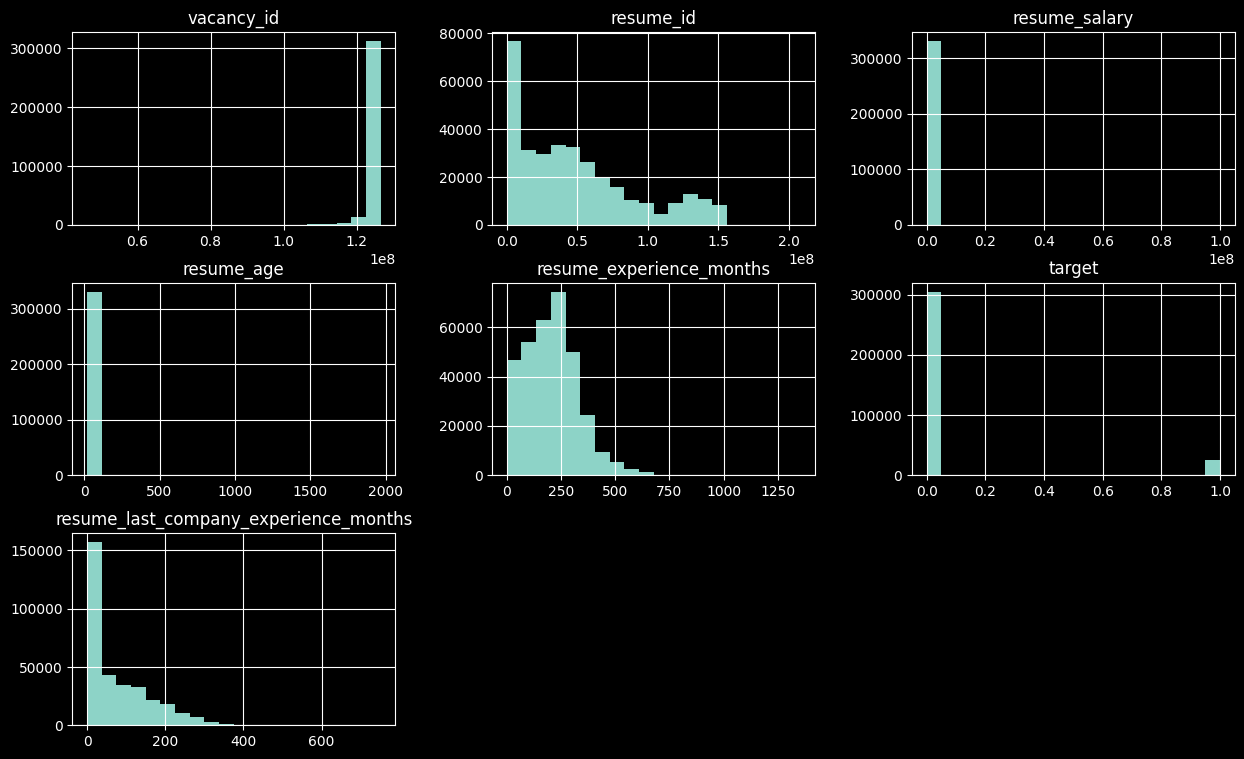

In [31]:
df.hist(bins=20, figsize=(15, 9));

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

- Ограничим выбросы по зарплате, потому что ровно одно значение по ожидаемой заработоной плате = 999,999,999 (смешно, но нет)

- Ограничим опыт общий и внутри одной компании до 720 месяцев (60 лет, ничего себе уже)

- Уберем возраст > 90, не ждем, что эти кандидаты находятся в поиске вакансии
</div>

In [32]:
df = df[~(df.resume_salary > 1e7)]
df.loc[df['resume_experience_months'] > 720, 'resume_experience_months'] = 720
df.loc[df['resume_last_company_experience_months'] > 720, 'resume_last_company_experience_months'] = 720
df = df[~(df.resume_age > 90)]



<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

- Также уберем строки, где последний опыт кандидата больше, чем общий

- И где общий опыт кандидата +16 лет больше чем возраст (хоть так)

</div>

In [33]:
df = df[~(df.resume_experience_months < df.resume_last_company_experience_months)]
df = df[~(df.resume_age < (df.resume_experience_months // 12) + 16)]

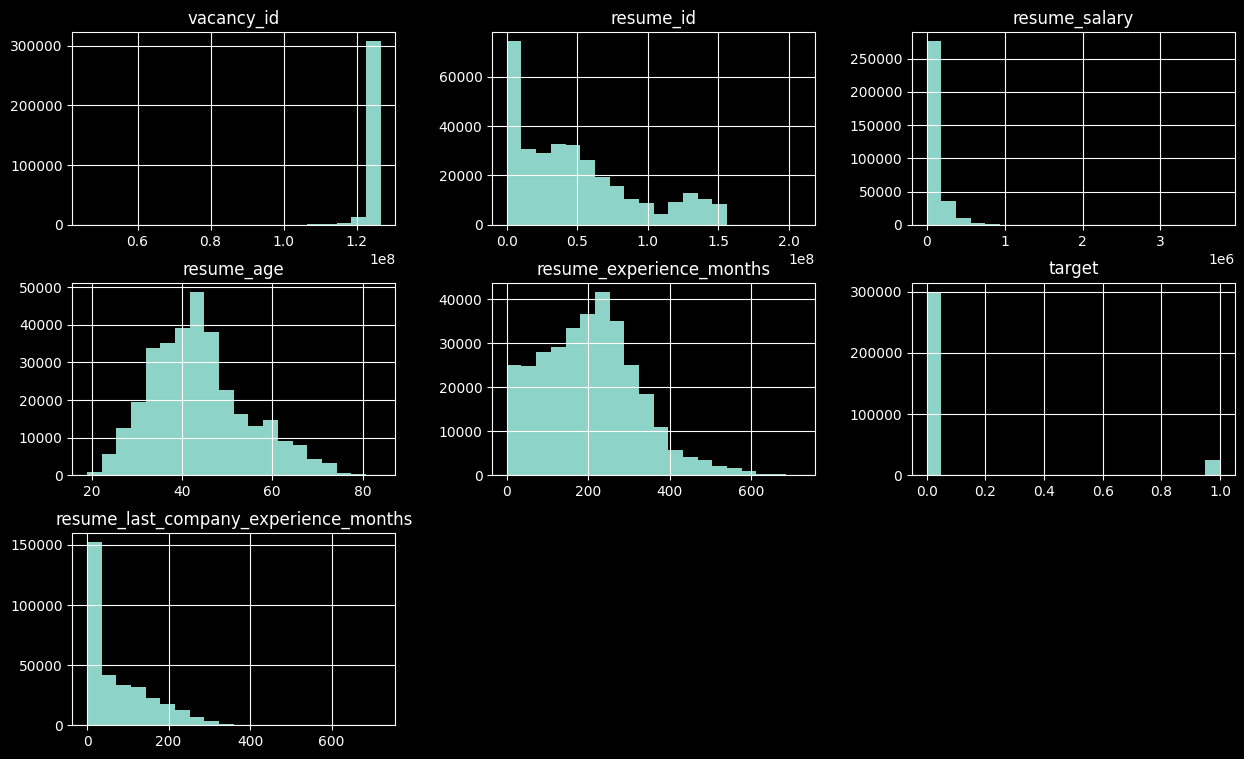

In [34]:
df.hist(bins=20, figsize=(15, 9));

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Теперь приведем остальные значения в датасете к порядку:
</div>

In [92]:
# Заменим текущий формат разброса полов в датасете на унифицированный:
gender_map = {
    'Мужчина': 'Мужчина',
    'Male': 'Мужчина',
    'Женщина': 'Женщина',
    'Female': 'Женщина'
}

df['resume_gender'] = df['resume_gender'].apply(lambda x: gender_map[x] if x in gender_map else 'Неизвестно')

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Посмотрим, какая доля мужчин и женщин в датасете:
</div>

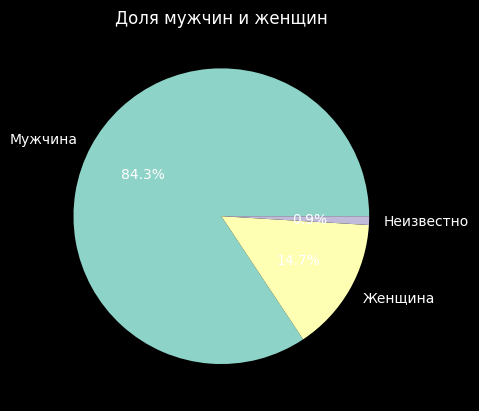

In [93]:
df['resume_gender'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', ylabel='', title='Доля мужчин и женщин');

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Взглянем на остальные категориальные признаки в датасете:
</div>

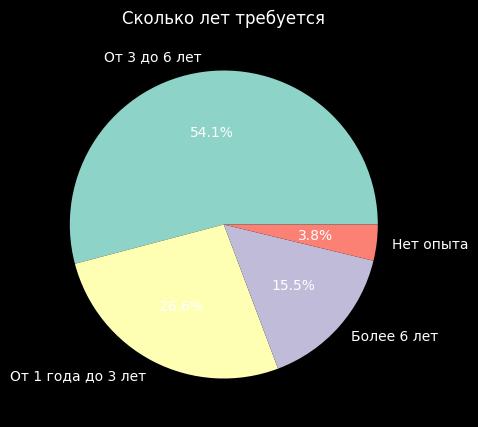

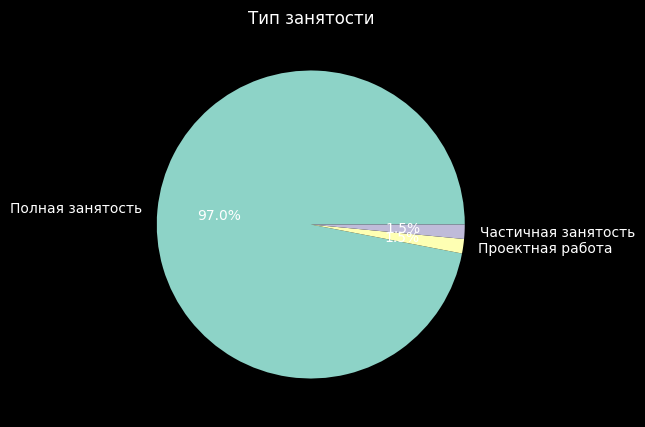

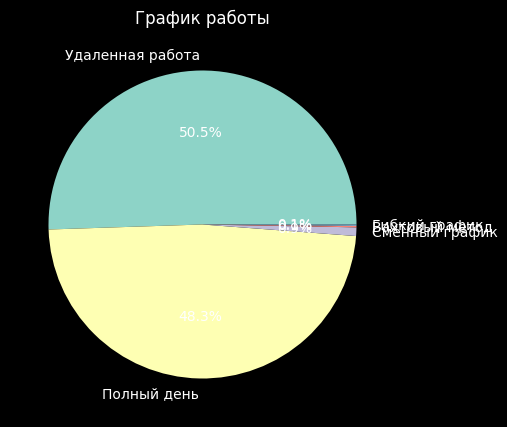

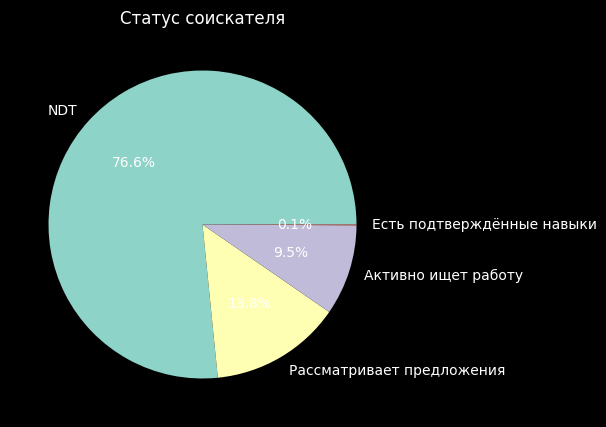

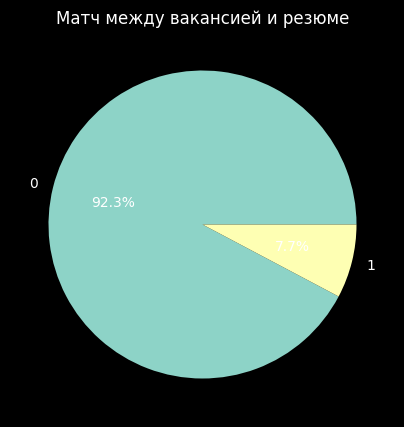

In [37]:
titles = {
    'vacancy_experience': 'Сколько лет требуется',
    'vacancy_employment': 'Тип занятости',
    'vacancy_schedule': 'График работы',
    'resume_applicant_status': 'Статус соискателя',
    'target': 'Матч между вакансией и резюме'
}

for col, title in titles.items():
    df[col].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', ylabel='', title=title, figsize=(5, 5))
    plt.show()


<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

- Заметим, что мужчины составляют 84% от датасета (не сами резюме, а матчинг вакансия - резюме)
- Датасет включает вакансии с требованием уровня эксперта (от 3-х лет)
- Матч резюме с удаленной работой составляет 50% и почти полностью из строк с полной занятостью
- Матч резюме составляет всего лишь 9.5% кандидатов с активным поиском

</div>

In [38]:
df["resume_applicant_status"].value_counts()

resume_applicant_status
NDT                           249324
Рассматривает предложения      44909
Активно ищет работу            31032
Есть подтверждённые навыки       278
Name: count, dtype: int64

In [39]:
# Поправим значения статуса кандидатов:

df["resume_applicant_status"] = df["resume_applicant_status"].replace("Есть подтверждённые навыки", "Рассматривает предложения")
df["resume_applicant_status"] = df["resume_applicant_status"].replace("NDT", "Рассматривает предложения")

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Теперь, когда мы привели данные к нужному виду, избавились от пропусков и выбросов в данных, проверили датасет на ошибки, можно приступить к изучению влияния признаков на целевую переменную:

</div>

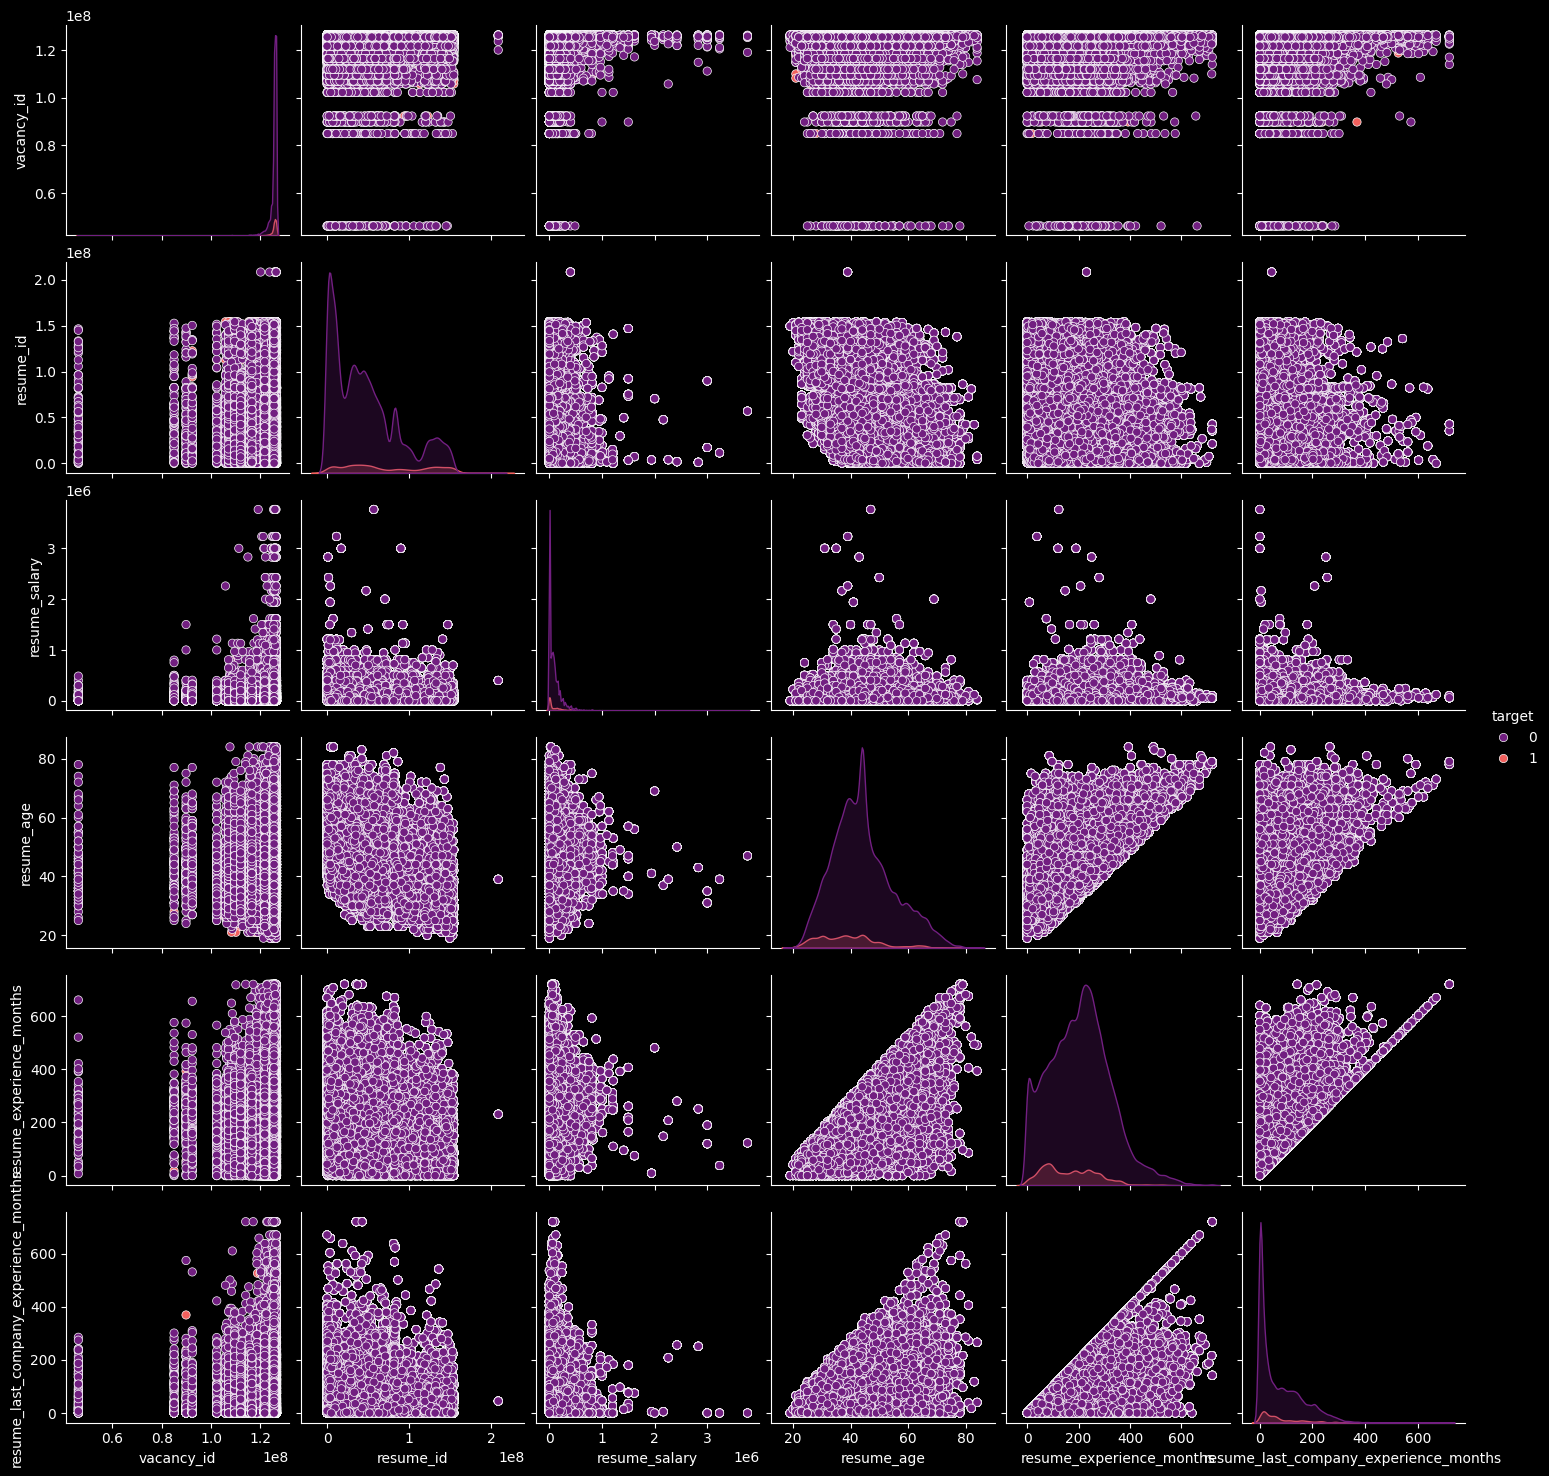

In [40]:
sns.pairplot(df, hue="target", palette="magma");

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Будем исследовать сначала количественные признаки

Заметим несколько понятных вещей:

- возраст кандидата и зарплата имеют колоколообразное распределение, медиана зарплат наступает в среднем возрасте. В начале карьерного опыта кандидаты ожидают получать меньше, чем более опытные кандидаты и кандидаты пенсионного возраста также начинают требовать меньших зарплат с увеличением возраста

- Распределение зарплат и всего опыта кандидата имеет похожее распределенеие.

- Однако, последние опыт кандидата и его зарплатные ожидания имеют строго отрицательную взаимосвязь. Нужно будет посмотреть, как это связано вкупе с возрастом

- Опыт (общий и последний) и возраст строго сонаправлены, что не имеет для нас ценности, убеждаемся еще раз, что ошибок в данных нет)

</div>

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Дальнейшее разбиение количественных показателей на Target / Gender / Vacancy experience / Resume applicant status / Resume location
не дали каких-то интересных зависимостей

Рассмотрим дальше корреляцию между признаками

Будем дальше рассматривать количественные и качественные признаки более детально

</div>

In [41]:
def correlation_check(df, metric_x, metric_y):

    phik_corr = df[[metric_x, metric_y]].phik_matrix(interval_cols=[metric_x, metric_y]).loc[metric_x, metric_y]
    pearson_corr = df[metric_x].corr(df[metric_y], method='pearson')

    return pearson_corr, phik_corr


In [42]:
out = []
columns = ['resume_salary', 'resume_age', 'resume_experience_months', 'resume_last_company_experience_months']
for k in range(len(columns)):
    metric_x = columns[k]
    for p in columns[k+1::]:
        metric_y = p
        pearson_corr, phik_corr = correlation_check(df, metric_x, metric_y)
        out.append([metric_x, metric_y, pearson_corr, phik_corr])
corr_table = pd.DataFrame(out, columns=['metric_x', 'metric_y', 'Линейная корреляция', 'Нелинейная корреляция'])
corr_table

,metric_x,metric_y,Линейная корреляция,Нелинейная корреляция
0,resume_salary,resume_age,0.070233,0.066976
1,resume_salary,resume_experience_months,0.121764,0.090639
2,resume_salary,resume_last_company_experience_months,-0.005432,0.081465
3,resume_age,resume_experience_months,0.695877,0.814175
4,resume_age,resume_last_company_experience_months,0.298160,0.441949
5,resume_experience_months,resume_last_company_experience_months,0.488443,0.733285


<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Взглянем еще на разброс корреляций для строк с кандидатами, которые подходят на вакансию и на кандидатов - мужчин:

</div>

In [43]:
out = []
columns = ['resume_salary', 'resume_age', 'resume_experience_months', 'resume_last_company_experience_months']
for k in range(len(columns)):
    metric_x = columns[k]
    for p in columns[k+1::]:
        metric_y = p
        pearson_corr, phik_corr = correlation_check(df[df.target == 1], metric_x, metric_y)
        out.append([metric_x, metric_y, pearson_corr, phik_corr])
corr_table = pd.DataFrame(out, columns=['metric_x', 'metric_y', 'Линейная корреляция', 'Нелинейная корреляция'])
corr_table

,metric_x,metric_y,Линейная корреляция,Нелинейная корреляция
0,resume_salary,resume_age,0.019517,0.237180
1,resume_salary,resume_experience_months,0.052027,0.208081
2,resume_salary,resume_last_company_experience_months,-0.039489,0.160156
3,resume_age,resume_experience_months,0.772737,0.824917
4,resume_age,resume_last_company_experience_months,0.390417,0.623367
5,resume_experience_months,resume_last_company_experience_months,0.531776,0.796255


In [44]:
out = []
columns = ['resume_salary', 'resume_age', 'resume_experience_months', 'resume_last_company_experience_months']
for k in range(len(columns)):
    metric_x = columns[k]
    for p in columns[k+1::]:
        metric_y = p
        pearson_corr, phik_corr = correlation_check(df[df.resume_gender == 'Мужчина'], metric_x, metric_y)
        out.append([metric_x, metric_y, pearson_corr, phik_corr])
corr_table = pd.DataFrame(out, columns=['metric_x', 'metric_y', 'Линейная корреляция', 'Нелинейная корреляция'])
corr_table

,metric_x,metric_y,Линейная корреляция,Нелинейная корреляция
0,resume_salary,resume_age,0.064437,0.051132
1,resume_salary,resume_experience_months,0.117855,0.063876
2,resume_salary,resume_last_company_experience_months,-0.016010,0.061906
3,resume_age,resume_experience_months,0.700111,0.822326
4,resume_age,resume_last_company_experience_months,0.288787,0.452405
5,resume_experience_months,resume_last_company_experience_months,0.481517,0.723751


<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Каких-то интересных корреляций найдено не было, возраст и опыт, понятное дело, сонаправлены.

</div>

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Построим нужные нам графики и начнем с конца, будем изучать влияния признаков в резюме на принятие и отказ

Напомниаю:
 - target = 1 - кандидата позвали на эту вакансию,
 - target = 0 - кандидата НЕ позвали на эту вакансию
</div>

In [45]:
def create_bar_chart(df, metric):

    t1 = ((df[df.target == 1].groupby([metric]).target.count() /\
          df.groupby([metric]).target.count()) * 100).reset_index()
    t1 = t1.merge(df[df.target == 1].groupby([metric]).target.count(), how='left', on = [metric])
    t1.rename(columns={'target_x': 1, 'target_y': 'cnt_1'}, inplace=True)

    t0 = ((df[df.target == 0].groupby([metric]).target.count() /\
          df.groupby([metric]).target.count()) * 100).reset_index()
    t0 = t0.merge(df[df.target == 0].groupby([metric]).target.count(), how='left', on = [metric])
    t0.rename(columns={'target_x': 0, 'target_y': 'cnt_0'}, inplace=True)

    t = t1.merge(t0, how='left', on = [metric])

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(t[metric], t[0], label='Target = 0', color='red')
    ax.bar(t[metric], t[1], bottom=t[0], label='Target = 1', color='blue')

    ax.set_title(f"Распределение целевого признака по {metric}", fontsize=14)
    ax.set_xlabel(metric)
    ax.set_ylabel("%")
    ax.set_ylim(0, 100)
    ax.legend(title="Target")

    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()

    return plt.show()

In [46]:
def create_scatter_chart(df, metric):

    t1 = ((df[df.target == 1].groupby([metric]).target.count() /\
          df.groupby([metric]).target.count()) * 100).reset_index()
    t1 = t1.merge(df[df.target == 1].groupby([metric]).target.count(), how='left', on = [metric])
    t1.rename(columns={'target_x': 1, 'target_y': 'cnt_1'}, inplace=True)

    t0 = ((df[df.target == 0].groupby([metric]).target.count() /\
          df.groupby([metric]).target.count()) * 100).reset_index()
    t0 = t0.merge(df[df.target == 0].groupby([metric]).target.count(), how='left', on = [metric])
    t0.rename(columns={'target_x': 0, 'target_y': 'cnt_0'}, inplace=True)

    t = t1.merge(t0, how='left', on = [metric])

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(t[metric], t[0], label="Target = 0", color='red')
    ax.fill_between(t[metric], t[0], color='red', alpha=0.3)

    ax.plot(t[metric], t[1], label="Target = 1", color='blue')
    ax.fill_between(t[metric], t[1], color='blue', alpha=0.3)

    ax.set_title(f"Распределение целевого признака по {metric}", fontsize=14)
    ax.set_xlabel(metric)
    ax.set_ylabel("%")
    ax.set_ylim(0, 100)
    ax.legend(title="Target")
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()

    return plt.show()

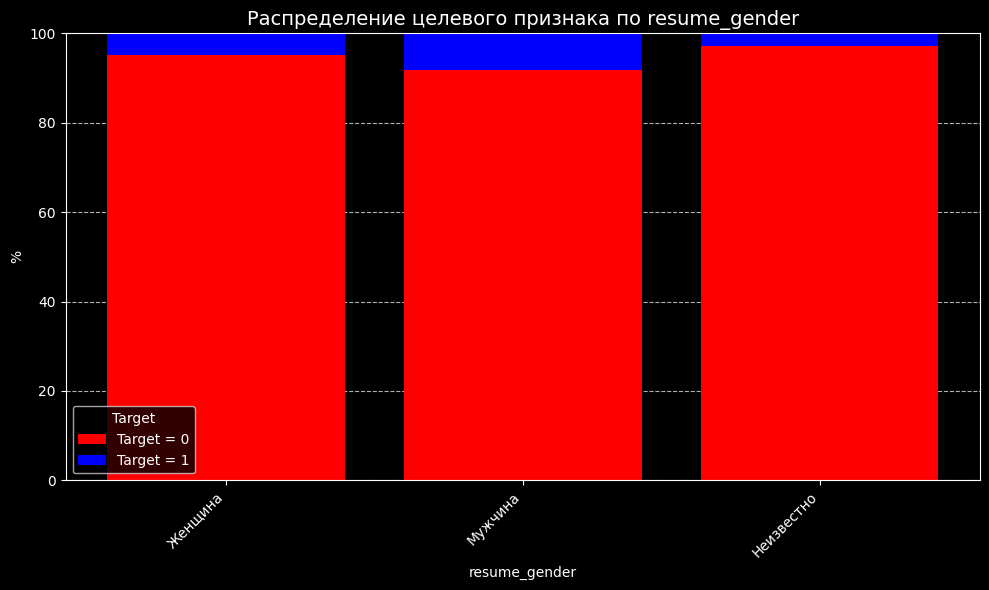

In [47]:
create_bar_chart(df, 'resume_gender')

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Мужчин гораздо чаще принимают на вакансию (относительно на 71% больше)

</div>

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Рассмотрим влияние возраста на таргет:

</div>

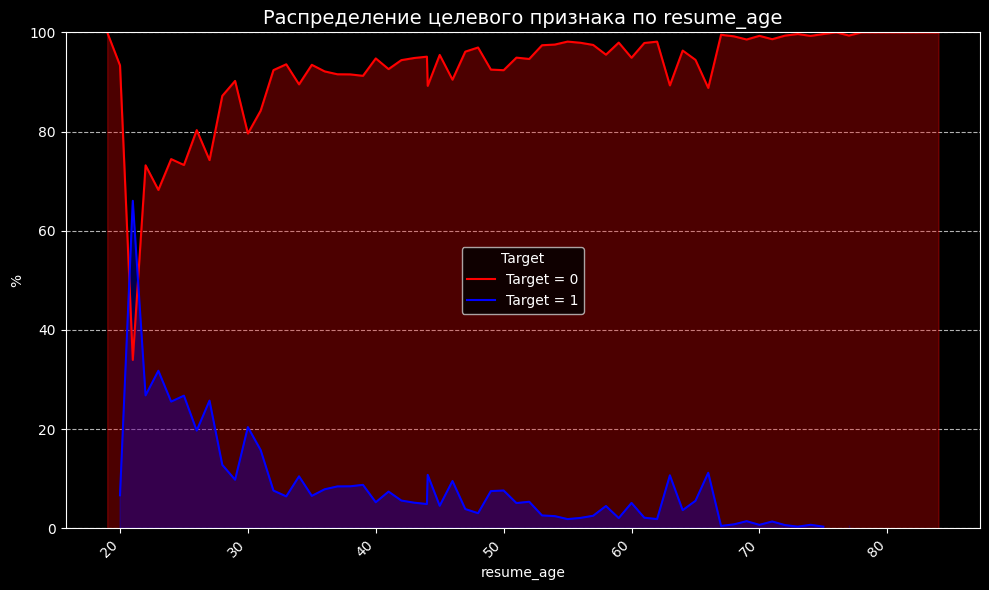

In [48]:
create_scatter_chart(df, 'resume_age')

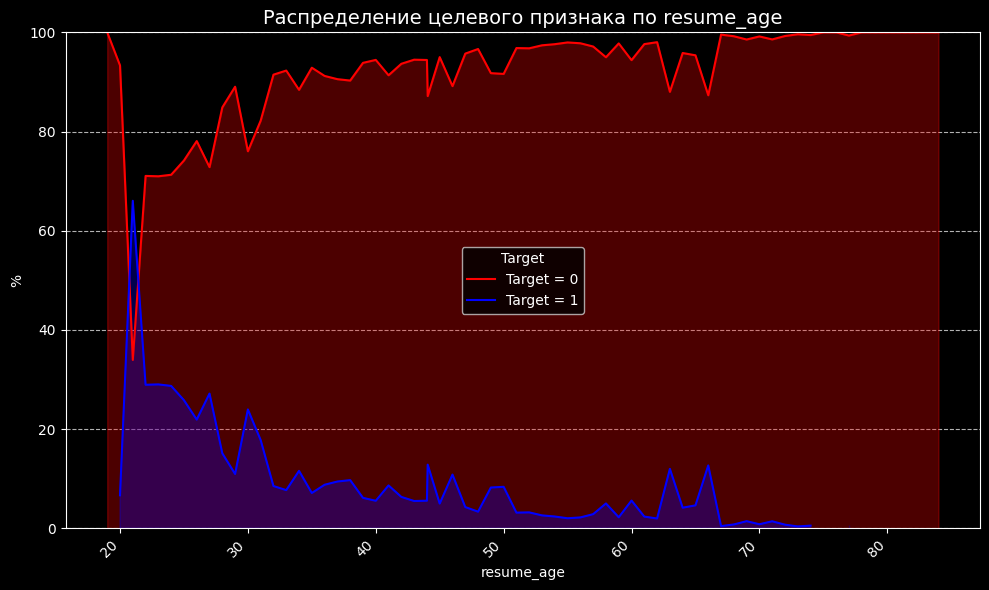

In [49]:
create_scatter_chart(df[df.resume_gender == 'Мужчина'], 'resume_age')

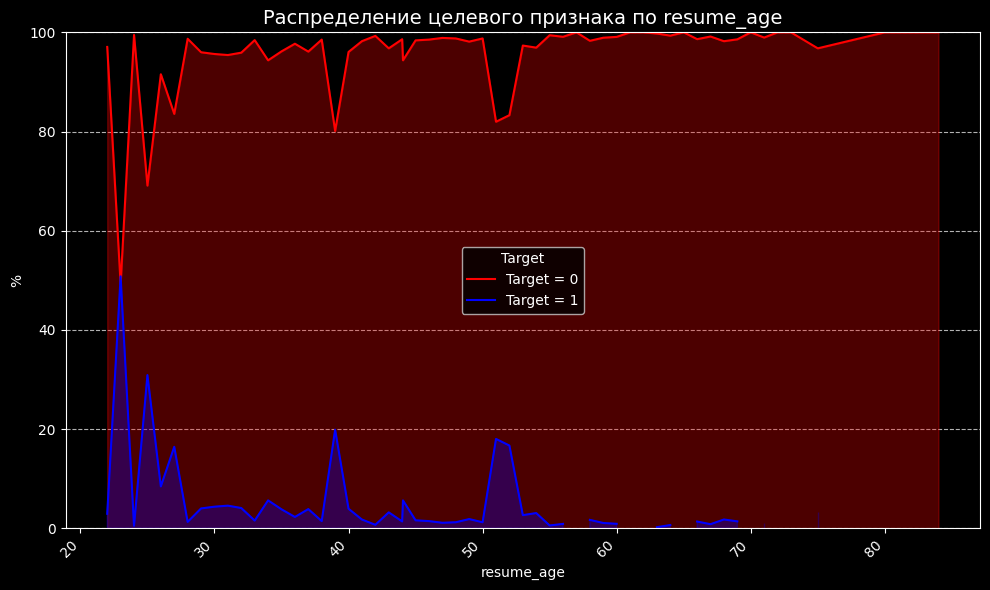

In [50]:
create_scatter_chart(df[df.resume_gender == 'Женщина'], 'resume_age')

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Видим линейную зависимость: чем больше возраст, тем выше доля отказов, как у женщин, так и мужчин.

Но надо сразу отметить, что у женщин доля отказов достигает 80% гораздо раньше, чем у мужчин (28 лет у женщин против 54 лет у мужчин)

</div>

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Теперь рассмотрим влияние ожидаемой заработной платы на таргет

Для этого поделим зарплату на разные бакеты, чтобы график читался легче

</div>

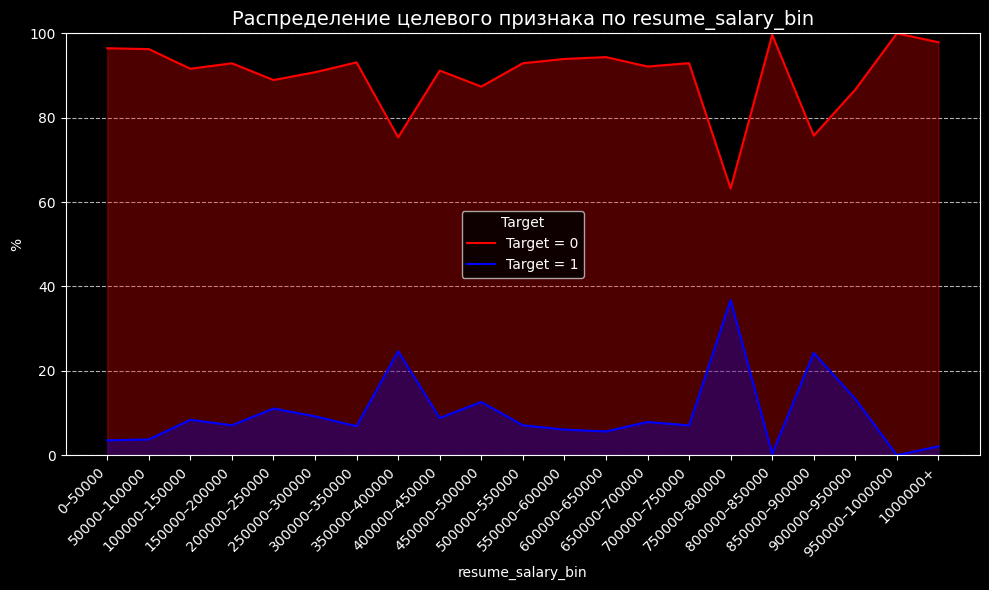

In [51]:
bucket = list(range(0, 1_000_001, 50_000)) + [np.inf]

labels = [f"{bucket[i]}–{bucket[i+1]}" for i in range(len(bucket)-2)] + ["1000000+"]

df["resume_salary_bin"] = pd.cut(
    df["resume_salary"],
    bins=bucket,
    labels=labels,
    include_lowest=True
)

create_scatter_chart(df[(df.resume_salary > 0)], 'resume_salary_bin')


<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Линейной зависимости не наблюдается, разброс значений с ростом зарплаты, скорее, говорит о снижении кол-во наблюдений в датасете, чем о паттерне.

</div>

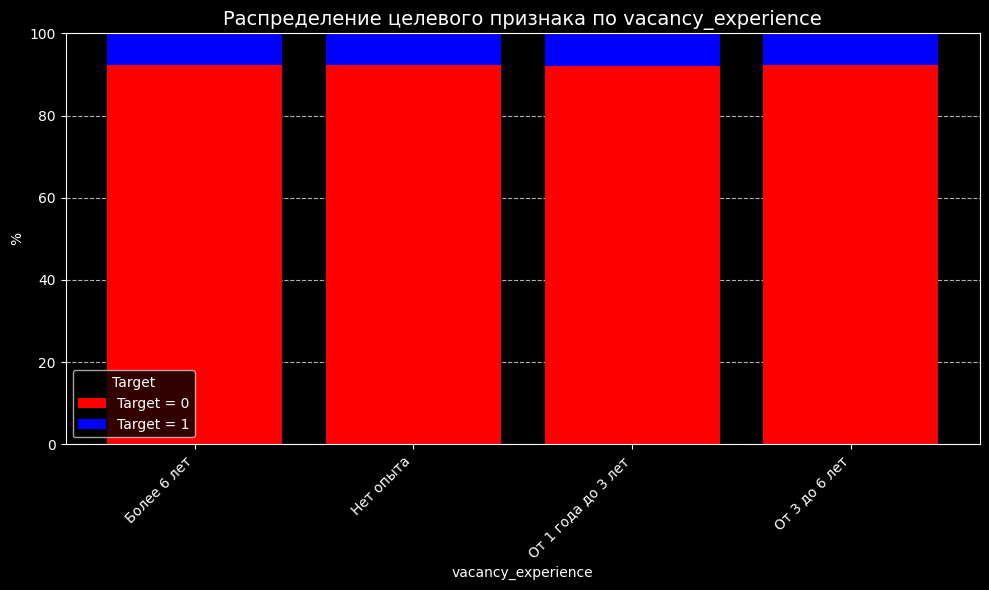

In [52]:
create_bar_chart(df, 'vacancy_experience')

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Идеально) Одинаковый уровень принятия на все вакансии

</div>

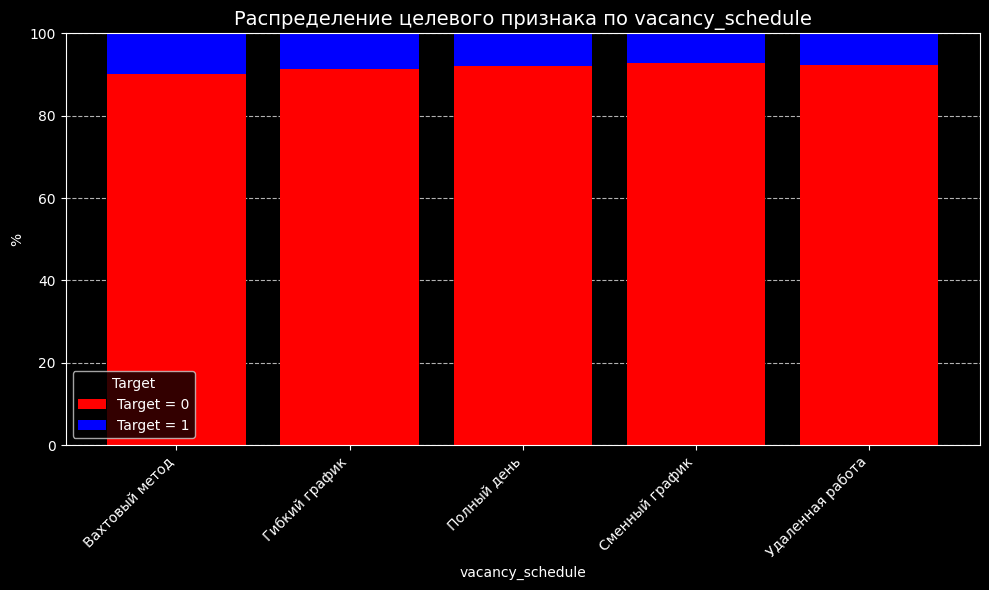

In [53]:
create_bar_chart(df, 'vacancy_schedule')

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Также, имеем примерно одинаковый уровень принятия

</div>

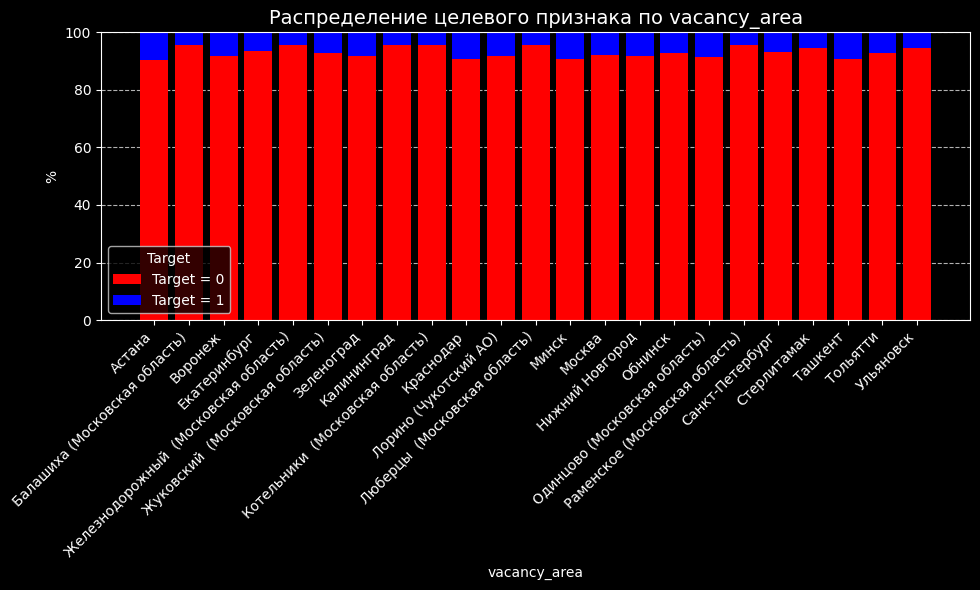

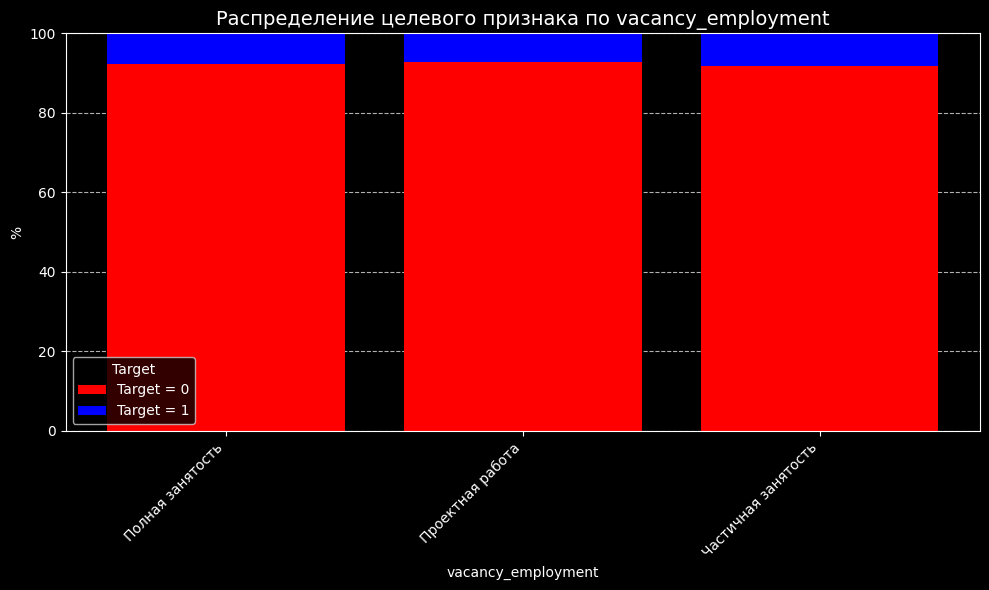

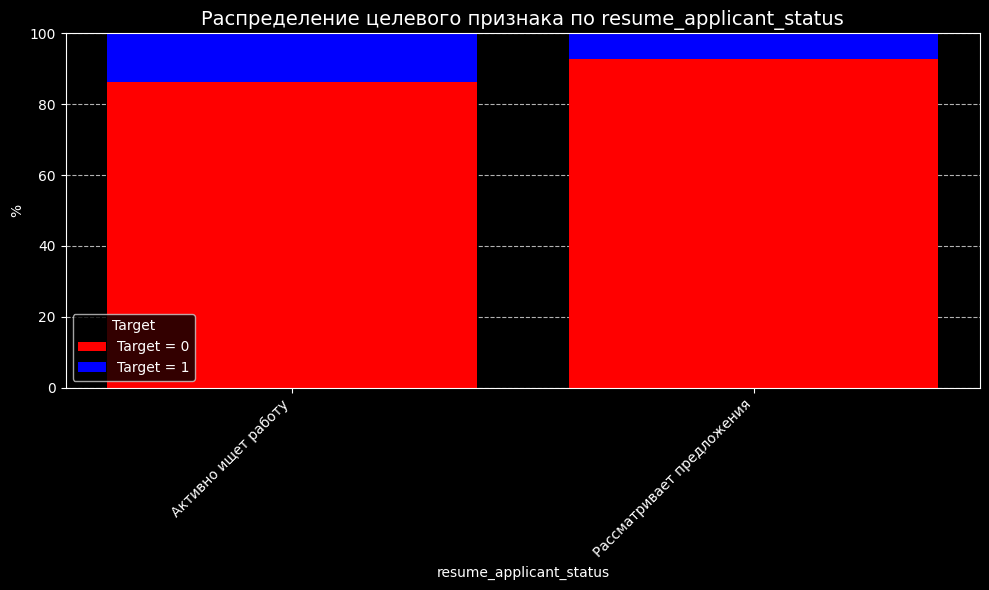

In [54]:
create_bar_chart(df, 'vacancy_area')
create_bar_chart(df, 'vacancy_employment')
create_bar_chart(df, 'resume_applicant_status')

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Рассмотрели категориальные признаки, которые имели меньше 100 уникальных значений

У resume_location - 570 уникальных значений

Из интересного только то, что есть разный уровень принятия у тех, кто активно ищет работу и тех, кто только рассматривает предложения.

</div>

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">
Посмотрим на ТОП навыков у кандидатов
</div>

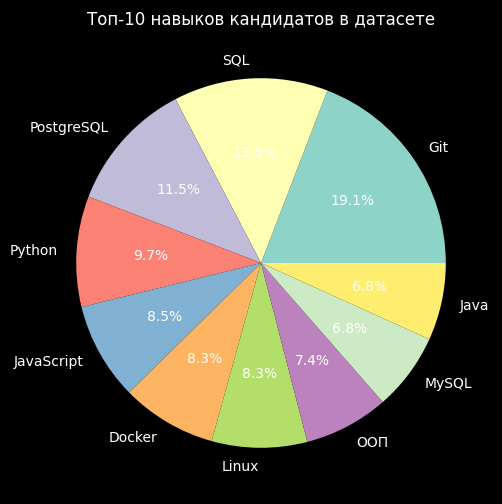

In [55]:
temp = df[['resume_skills']].copy()

temp['resume_skills'] = temp['resume_skills'].astype(str).str.replace(r"[\[\]']", '', regex=True)

temp['resume_skills'] = temp['resume_skills'].str.split(',').explode('resume_skills')

temp['resume_skills'] = temp['resume_skills'].str.strip()

temp['resume_skills'].value_counts(normalize=True).head(10).plot(kind='pie', autopct='%1.1f%%', ylabel='', title='Топ-10 навыков кандидатов в датасете', figsize=(6,6))
plt.show()

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Сделаем новый признак, а именно посчитаем количество навыков кандидата, которые указаны в вакансии.

</div>

In [56]:
def resume_skill_count(row):
    count = 0
    skill_list = row['resume_skills'].replace('[', '').replace(']', '').replace("'", "").split(', ')
    for i in skill_list:
        if i in row['vacancy_description']:
            count += 1
    return count

df['resume_skill_count'] = df.apply(resume_skill_count, axis=1)

df[['vacancy_description', 'resume_skills', 'resume_skill_count']]

,vacancy_description,resume_skills,resume_skill_count
0,"Привет!.redev — технологическая компания, созд...","['ООП', 'SAP MM', 'SAP FI', 'SAP ERP', 'SQL', ...",3
1,"Привет!.redev — технологическая компания, созд...","['ABAP', 'SAP HR', 'PA', 'OM', 'PT', 'PY', 'SA...",2
2,"Привет!.redev — технологическая компания, созд...",['•\tвладение принципами объектно-ориентирован...,1
3,"Привет!.redev — технологическая компания, созд...","['SAP', 'ABAP', 'CDS', 'AMDP', 'RFC', 'Enhance...",2
4,"Привет!.redev — технологическая компания, созд...","['ABAP', 'SAP BW', 'ALV grid', 'ALV tree', 'AB...",2
...,...,...,...
332325,Мы — Wildberries. Мы — это крупнейший маркетпл...,NDT,0
332326,Мы — Wildberries. Мы — это крупнейший маркетпл...,['Иностранный язык: Английский со словарем. Ра...,0
332327,Мы — Wildberries. Мы — это крупнейший маркетпл...,"['Управление проектами', 'Управление командой'...",0
332328,Мы — Wildberries. Мы — это крупнейший маркетпл...,"['MS Office', 'Английский язык', 'MATLAB', 'IB...",0


<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Теперь закодируем описание вакансии и последнего опыта работы разными способами и сравним через косинусное расстояние.

</div>

## Common functions

In [57]:
# Предобработка данных
def preprocess_data(df):
    """Обработка пропущенных значений в текстовых полях"""
    print("Проверка пропущенных значений...")
    print(f"Пропуски в vacancy_description: {df['vacancy_description'].isna().sum()}")
    print(f"Пропуски в resume_last_experience_description: {df['resume_last_experience_description'].isna().sum()}")
    
    # Заполняем пропуски пустыми строками
    df['vacancy_description'] = df['vacancy_description'].fillna('')
    df['resume_last_experience_description'] = df['resume_last_experience_description'].fillna('')
    
    # Проверяем, что все значения теперь строковые
    df['vacancy_description'] = df['vacancy_description'].astype(str)
    df['resume_last_experience_description'] = df['resume_last_experience_description'].astype(str)
    
    return df

In [58]:
# Сохранение результатов
def save_results(df, output_file):
    """Сохранение результатов в CSV файл"""
    df.to_csv(output_file, index=False, encoding='utf-8')
    print(f"Результаты сохранены в файл: {output_file}")

In [59]:
# Вычисление косинусного сходства
def calculate_cosine_similarity(embeddings1, embeddings2):
    """Вычисление косинусного сходства между двумя наборами эмбеддингов"""
    similarities = []
    
    for i in tqdm(range(embeddings1.shape[0])):
        emb1_row = embeddings1[i]
        emb2_row = embeddings2[i]
        
        similarity = cosine_similarity(emb1_row, emb2_row)[0][0]
        similarities.append(similarity)
    
    return similarities

# TF-IDF

In [60]:
warnings.filterwarnings('ignore')

# Скачиваем необходимые ресурсы NLTK
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('taggers/averaged_perceptron_tagger_ru')
except LookupError:
    nltk.download('averaged_perceptron_tagger_ru')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

morph = pymorphy3.MorphAnalyzer()

[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [61]:
# Функция лемматизации для русского языка
def lemmatize_russian(tokens):
    """Лемматизация русских слов"""
    lemmas = []
    for token in tokens:
        parsed = morph.parse(token)[0]  # Берем самый вероятный разбор
        lemmas.append(parsed.normal_form)
    return lemmas

In [62]:
# Токенизация текста с лемматизацией
def tokenize_and_lemmatize(text):
    """Токенизация текста с лемматизацией и удалением стоп-слов"""
    # Базовая токенизация
    tokens = simple_preprocess(text, deacc=True, min_len=2)
    
    # Удаляем стоп-слова
    stop_words = set(stopwords.words('russian') + stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Лемматизация для русских слов
    lemmatized_tokens = lemmatize_russian(tokens)
    
    return lemmatized_tokens

In [63]:
# Токенизация для TF-IDF (возвращает строку с лемматизированными токенами)
def tokenize_for_tfidf(text):
    """Токенизация для TF-IDF с лемматизацией"""
    tokens = tokenize_and_lemmatize(text)
    return tokens

In [64]:
# Создание TF-IDF эмбеддингов с лемматизацией
def get_tfidf_embeddings(texts, vectorizer=None, fit=True):
    """Создание TF-IDF эмбеддингов для списка текстов с лемматизацией"""
    if fit:
        vectorizer = TfidfVectorizer(
            max_features=5000,
            min_df=2,
            max_df=0.8,
            ngram_range=(1, 2),
            tokenizer=tokenize_for_tfidf,
            token_pattern=None,
            lowercase=False  # Уже сделано в токенизации
        )
        embeddings = vectorizer.fit_transform(texts)
    else:
        embeddings = vectorizer.transform(texts)
    
    return embeddings, vectorizer

In [65]:
# Создание эмбеддингов для уникальных вакансий с лемматизацией
def get_tfidf_vacancy_embeddings(df, vectorizer=None):
    """Создание эмбеддингов для уникальных вакансий с лемматизацией"""
    unique_vacancies = df[['vacancy_id', 'vacancy_description']].drop_duplicates()
    
    unique_embeddings, vectorizer = get_tfidf_embeddings(
        unique_vacancies['vacancy_description'].tolist(), 
        vectorizer=vectorizer, 
        fit=(vectorizer is None)
    )
    
    # Создаем mapping: vacancy_id -> sparse row
    vacancy_embedding_dict = dict(zip(unique_vacancies['vacancy_id'], unique_embeddings))
    
    rows = []
    for vid in df['vacancy_id']:
        rows.append(vacancy_embedding_dict[vid])
    
    # Объединяем в одну sparse матрицу
    all_vacancy_embeddings = vstack(rows)
    
    return all_vacancy_embeddings, vectorizer

In [66]:
# Основная функция обработки для TF-IDF с лемматизацией
def process_similarity_scores_tfidf(df):
    """Функция для вычисления схожести с использованием TF-IDF и лемматизации"""    
    # Предобработка данных
    df = preprocess_data(df)
    
    # создание эмбеддингов для вакансий
    vacancy_embeddings, tfidf_vectorizer = get_tfidf_vacancy_embeddings(df)
    
    print("Создание TF-IDF эмбеддингов для описаний опыта в резюме...")
    experience_embeddings, _ = get_tfidf_embeddings(df['resume_last_experience_description'].tolist(), vectorizer=tfidf_vectorizer, fit=False)
    
    print("Вычисление косинусного сходства...")
    similarity_scores = calculate_cosine_similarity(vacancy_embeddings, experience_embeddings)
    
    # Добавляем scores в DataFrame
    df['similarity_score_tfidf'] = similarity_scores
    
    return df

In [69]:
df_tfidf = process_similarity_scores_tfidf(df.copy())
save_results(df_tfidf, 'description_df_with_scores_tfidf.csv')

Проверка пропущенных значений...
Пропуски в vacancy_description: 0
Пропуски в resume_last_experience_description: 0
Создание TF-IDF эмбеддингов для описаний опыта в резюме...
Вычисление косинусного сходства...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 325543/325543 [16:01<00:00, 338.49it/s]


Результаты сохранены в файл: description_df_with_scores_tfidf.csv


# Word2Vec

In [70]:
# Создание Word2Vec модели с лемматизацией
def train_word2vec_model(texts, vector_size=100, window=5, min_count=2):
    """Обучение Word2Vec модели на лемматизированных текстах"""
    print("Токенизация и лемматизация текстов для Word2Vec...")
    tokenized_texts = [tokenize_and_lemmatize(text) for text in tqdm(texts)]
    
    # Фильтруем пустые документы
    tokenized_texts = [tokens for tokens in tokenized_texts if len(tokens) > 0]
    
    print(f"Обучение Word2Vec модели на {len(tokenized_texts)} документах...")
    model = Word2Vec(
        sentences=tokenized_texts,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=4,
        sg=1,
        epochs=10
    )
    
    model.build_vocab(tokenized_texts, update=False)
    
    return model, tokenized_texts

In [71]:
# Создание SPARSE Word2Vec эмбеддингов
def get_word2vec_embeddings_sparse(texts, model, vocab_dict, vector_size=100):
    """Создание sparse Word2Vec эмбеддингов для списка текстов"""
    
    embeddings_data = []
    embeddings_indices = []
    embeddings_indptr = [0]
    
    for text in tqdm(texts):
        tokens = tokenize_and_lemmatize(text)
        word_indices = []
        word_weights = []
        
        for token in tokens:
            if token in vocab_dict:
                word_indices.append(vocab_dict[token])
                word_weights.append(1.0)  # Можно использовать TF или TF-IDF веса
        
        embeddings_data.extend(word_weights)
        embeddings_indices.extend(word_indices)
        embeddings_indptr.append(len(embeddings_data))
    
    # Создаем sparse матрицу
    embeddings = csr_matrix(
        (embeddings_data, embeddings_indices, embeddings_indptr),
        shape=(len(texts), len(vocab_dict))
    )
    
    return embeddings

In [72]:
# Оптимизированная функция для создания SPARSE эмбеддингов вакансий для Word2Vec
def get_word2vec_vacancy_embeddings_sparse(df, word2vec_model, vocab_dict):
    """Создание sparse эмбеддингов для уникальных вакансий"""
    # Получаем уникальные вакансии
    unique_vacancies = df[['vacancy_id', 'vacancy_description']].drop_duplicates()
    print(f"Найдено {len(unique_vacancies)} уникальных вакансий")

    # Создаем sparse эмбеддинги для уникальных вакансий
    unique_embeddings_sparse = get_word2vec_embeddings_sparse(
        unique_vacancies['vacancy_description'].tolist(), 
        word2vec_model, 
        vocab_dict
    )
    
    # Создаем словарь для быстрого доступа: vacancy_id -> sparse embedding
    vacancy_embedding_dict = {}
    for idx, vid in enumerate(unique_vacancies['vacancy_id']):
        vacancy_embedding_dict[vid] = unique_embeddings_sparse[idx]
    
    # Создаем маппинг для всего датасета как sparse матрицу
    embedding_rows = []
    for vid in df['vacancy_id']:
        embedding_rows.append(vacancy_embedding_dict[vid])
    
    all_vacancy_embeddings = vstack(embedding_rows)
    
    return all_vacancy_embeddings, word2vec_model

In [73]:
# Основная функция обработки для Word2Vec со sparse матрицами (исправленная)
def process_similarity_scores_word2vec_sparse(df):
    """Функция для вычисления схожести с использованием Word2Vec и sparse матриц"""    
    # Предобработка данных
    df = preprocess_data(df)
    
    # Объединяем все тексты для обучения Word2Vec
    all_texts = pd.concat([
        df['vacancy_description'].drop_duplicates(),
        df['resume_last_experience_description'].drop_duplicates()
    ]).tolist()
    
    # Обучаем Word2Vec модель
    word2vec_model, _ = train_word2vec_model(all_texts)
    
    print(f"Размер словаря Word2Vec: {len(word2vec_model.wv.key_to_index)}")
    
    # Создаем словарь для маппинга слов в индексы
    vocab_dict = {word: idx for idx, word in enumerate(word2vec_model.wv.key_to_index.keys())}
    
    print("Создание sparse Word2Vec эмбеддингов для вакансий...")
    # Используем исправленную функцию с sparse матрицами
    vacancy_embeddings_sparse, _ = get_word2vec_vacancy_embeddings_sparse(
        df, 
        word2vec_model, 
        vocab_dict
    )
    
    print("Создание sparse Word2Vec эмбеддингов для описаний опыта...")
    experience_embeddings_sparse = get_word2vec_embeddings_sparse(
        df['resume_last_experience_description'].tolist(), 
        word2vec_model, 
        vocab_dict
    )
    
    print("Вычисление косинусного сходства...")
    similarity_scores = calculate_cosine_similarity(
        vacancy_embeddings_sparse, 
        experience_embeddings_sparse
    )
    
    # Добавляем scores в DataFrame
    df['similarity_score_word2vec'] = similarity_scores
    
    return df

In [74]:
df_word2vec = process_similarity_scores_word2vec_sparse(df.copy())
save_results(df_word2vec, 'description_df_with_scores_word2vec.csv')

Проверка пропущенных значений...
Пропуски в vacancy_description: 0
Пропуски в resume_last_experience_description: 0
Токенизация и лемматизация текстов для Word2Vec...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23196/23196 [32:46<00:00, 11.80it/s]


Обучение Word2Vec модели на 23169 документах...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Размер словаря Word2Vec: 36890
Создание sparse Word2Vec эмбеддингов для вакансий...
Найдено 3409 уникальных вакансий


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3409/3409 [17:44<00:00,  3.20it/s]


Создание sparse Word2Vec эмбеддингов для описаний опыта...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 325543/325543 [3:45:56<00:00, 24.01it/s]


Вычисление косинусного сходства...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 325543/325543 [16:19<00:00, 332.21it/s]


Результаты сохранены в файл: description_df_with_scores_word2vec.csv


# Transformers

In [75]:
# Инициализация модели для эмбеддингов
def initialize_model(model_name='sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'):
    """Инициализация токенизатора и модели"""
    print("Инициализация модели...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    return tokenizer, model

In [76]:
# Создание sparse эмбеддингов для Transformers
def get_transformer_embeddings_sparse(texts, tokenizer, model, batch_size=8, sparsity_threshold=0.01):
    """Создание sparse эмбеддингов для списка текстов"""
    from scipy.sparse import csr_matrix
    import gc
    
    all_embeddings = []
    
    # Фильтруем пустые тексты
    processed_texts = []
    for text in texts:
        if isinstance(text, (str, np.str_)) and len(text.strip()) > 0:
            processed_texts.append(text.strip())
        else:
            processed_texts.append(" ")
    
    print(f"Обрабатывается {len(processed_texts)} текстов...")
    
    for i in tqdm(range(0, len(processed_texts), batch_size)):
        batch_texts = processed_texts[i:i+batch_size]
        
        try:
            # Токенизация
            encoded_input = tokenizer(
                batch_texts, 
                padding=True, 
                truncation=True, 
                max_length=512, 
                return_tensors='pt'
            )
            
            # Получение эмбеддингов
            with torch.no_grad():
                model_output = model(**encoded_input)
                embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
                batch_embeddings = embeddings.cpu().numpy()
                
                # Преобразуем в sparse
                for emb in batch_embeddings:
                    sparse_emb = csr_matrix(emb)
                    # Применяем порог sparsity
                    sparse_emb.data[np.abs(sparse_emb.data) < sparsity_threshold] = 0
                    sparse_emb.eliminate_zeros()
                    all_embeddings.append(sparse_emb)
                
        except Exception as e:
            print(f"Ошибка при обработке батча {i}: {e}")
            # Добавляем нулевые sparse эмбеддинги для проблемного батча
            for _ in range(len(batch_texts)):
                all_embeddings.append(csr_matrix((1, model.config.hidden_size)))
        
        # Очищаем память
        if i % (batch_size * 5) == 0:
            gc.collect()
    
    # Объединяем все sparse матрицы в одну большую sparse матрицу
    from scipy.sparse import vstack
    final_embeddings = vstack(all_embeddings)
    
    return final_embeddings

In [77]:
# Функция для усреднения эмбендингов
def mean_pooling(model_output, attention_mask):
    """Mean Pooling - берем среднее значение скрытых состояний"""
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [78]:
# Оптимизированная функция для создания SPARSE эмбеддингов вакансий для Transformers
def get_vacancy_embeddings_transformer_sparse(df, tokenizer, model, sparsity_threshold=0.01):
    """Создание sparse эмбеддингов для уникальных вакансий"""
    # Получаем уникальные вакансии
    unique_vacancies = df[['vacancy_id', 'vacancy_description']].drop_duplicates()
    print(f"Найдено {len(unique_vacancies)} уникальных вакансий")
    
    # Создаем sparse эмбеддинги только для уникальных вакансий
    print("Создание sparse эмбеддингов для уникальных вакансий...")
    unique_embeddings_sparse = get_transformer_embeddings_sparse(
        unique_vacancies['vacancy_description'].tolist(), 
        tokenizer, 
        model,
        sparsity_threshold=sparsity_threshold
    )
    
    # Создаем словарь для быстрого доступа: vacancy_id -> sparse embedding
    vacancy_embedding_dict = {}
    for idx, vid in enumerate(unique_vacancies['vacancy_id']):
        vacancy_embedding_dict[vid] = unique_embeddings_sparse[idx]
    
    # Создаем маппинг для всего датасета как sparse матрицу
    from scipy.sparse import vstack
    embedding_rows = []
    for vid in df['vacancy_id']:
        embedding_rows.append(vacancy_embedding_dict[vid])
    
    all_vacancy_embeddings = vstack(embedding_rows)
    
    return all_vacancy_embeddings

In [79]:
# Основная функция обработки для Transformers со sparse матрицами (исправленная)
def process_similarity_scores_transformer_sparse(df, tokenizer, model):
    """Оптимизированная функция для вычисления схожести с использованием Transformers и sparse матриц"""
    # Предобработка данных
    df = preprocess_data(df)
    
    # Оптимизированное создание sparse эмбеддингов для вакансий
    print("Создание sparse эмбеддингов для вакансий...")
    vacancy_embeddings = get_vacancy_embeddings_transformer_sparse(
        df, 
        tokenizer, 
        model
    )
    
    print("Создание sparse эмбеддингов для описаний опыта в резюме...")
    experience_embeddings = get_transformer_embeddings_sparse(
        df['resume_last_experience_description'].tolist(), 
        tokenizer, 
        model
    )
    
    print("Вычисление косинусного сходства...")
    similarity_scores = calculate_cosine_similarity(
        vacancy_embeddings, 
        experience_embeddings
    )
    
    # Добавляем scores в DataFrame
    df['similarity_score_transformer'] = similarity_scores
    
    return df

In [80]:
model_name = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
tokenizer, model = initialize_model(model_name)

# Вычисление схожести
df_transformer = process_similarity_scores_transformer_sparse(df, tokenizer, model)

Инициализация модели...
Проверка пропущенных значений...
Пропуски в vacancy_description: 0
Пропуски в resume_last_experience_description: 0
Создание sparse эмбеддингов для вакансий...
Найдено 3409 уникальных вакансий
Создание sparse эмбеддингов для уникальных вакансий...
Обрабатывается 3409 текстов...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 427/427 [1:08:25<00:00,  9.61s/it]


Создание sparse эмбеддингов для описаний опыта в резюме...
Обрабатывается 325543 текстов...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40693/40693 [54:23:58<00:00,  4.81s/it]


Вычисление косинусного сходства...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 325543/325543 [01:04<00:00, 5029.61it/s]


In [81]:
df = df.merge(df_tfidf).merge(df_word2vec).merge(df_transformer)

In [82]:
df

,vacancy_id,vacancy_name,vacancy_area,vacancy_experience,vacancy_employment,vacancy_schedule,vacancy_description,resume_id,resume_title,resume_specialization,...,resume_location,resume_gender,resume_applicant_status,target,resume_last_company_experience_months,resume_salary_bin,resume_skill_count,similarity_score_transformer,similarity_score_tfidf,similarity_score_word2vec
0,126167948,Разработчик SAP ABAP,Москва,Более 6 лет,Полная занятость,Удаленная работа,"Привет!.redev — технологическая компания, созд...",6969174,ABAP-разработчик,"['Программист, разработчик']",...,Москва,Мужчина,Рассматривает предложения,1,76.0,0–50000,3,0.386884,0.354339,0.516185
1,126167948,Разработчик SAP ABAP,Москва,Более 6 лет,Полная занятость,Удаленная работа,"Привет!.redev — технологическая компания, созд...",9100077,"ABAP разработчик - SAP HCM, CRM, S/4HANA ERP(F...","['Программист, разработчик']",...,Москва,Мужчина,Рассматривает предложения,1,8.0,0–50000,2,0.460611,0.472020,0.369648
2,126167948,Разработчик SAP ABAP,Москва,Более 6 лет,Полная занятость,Удаленная работа,"Привет!.redev — технологическая компания, созд...",32644957,Разработчик ABAP,"['Программист, разработчик']",...,Москва,Женщина,Рассматривает предложения,1,136.0,150000–200000,1,0.438212,0.633376,0.743483
3,126167948,Разработчик SAP ABAP,Москва,Более 6 лет,Полная занятость,Удаленная работа,"Привет!.redev — технологическая компания, созд...",27220466,ABAP-разработчик,"['Программист, разработчик']",...,Красноярск,Мужчина,Рассматривает предложения,1,135.0,450000–500000,2,0.369321,0.435246,0.507833
4,126167948,Разработчик SAP ABAP,Москва,Более 6 лет,Полная занятость,Удаленная работа,"Привет!.redev — технологическая компания, созд...",7532708,ABAP разработчик. Senior ABAP Developer. SAP T...,"['Programmer, developer']",...,Moscow,Мужчина,Рассматривает предложения,1,0.0,0–50000,2,0.215726,0.137066,0.082912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325538,125547086,Golang developer (IT банк),Москва,От 3 до 6 лет,Полная занятость,Удаленная работа,Мы — Wildberries. Мы — это крупнейший маркетпл...,255135,"Управляющий недвижимостью, Директор по управле...",['Агент по недвижимости'],...,Санкт-Петербург,Женщина,Рассматривает предложения,0,270.0,200000–250000,0,0.707073,0.041374,0.297626
325539,125547086,Golang developer (IT банк),Москва,От 3 до 6 лет,Полная занятость,Удаленная работа,Мы — Wildberries. Мы — это крупнейший маркетпл...,34423776,"Директор, Операционный директор,Технический ди...","['Механик', 'Технический директор (CTO)']",...,Москва,Мужчина,Активно ищет работу,0,35.0,0–50000,0,0.330166,0.000000,0.000000
325540,125547086,Golang developer (IT банк),Москва,От 3 до 6 лет,Полная занятость,Удаленная работа,Мы — Wildberries. Мы — это крупнейший маркетпл...,54564265,Интернет-маркетолог,"['Менеджер по маркетингу, интернет-маркетолог']",...,Москва,Мужчина,Рассматривает предложения,0,44.0,50000–100000,0,0.668410,0.030688,0.207074
325541,125547086,Golang developer (IT банк),Москва,От 3 до 6 лет,Полная занятость,Удаленная работа,Мы — Wildberries. Мы — это крупнейший маркетпл...,70588832,Менеджер по продукту,"['Менеджер продукта', 'Руководитель проектов']",...,Москва,Женщина,Рассматривает предложения,0,96.0,0–50000,0,0.391920,0.018629,0.086176


interval columns not set, guessing: ['target', 'similarity_score_tfidf', 'similarity_score_word2vec', 'similarity_score_transformer', 'resume_skill_count']


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

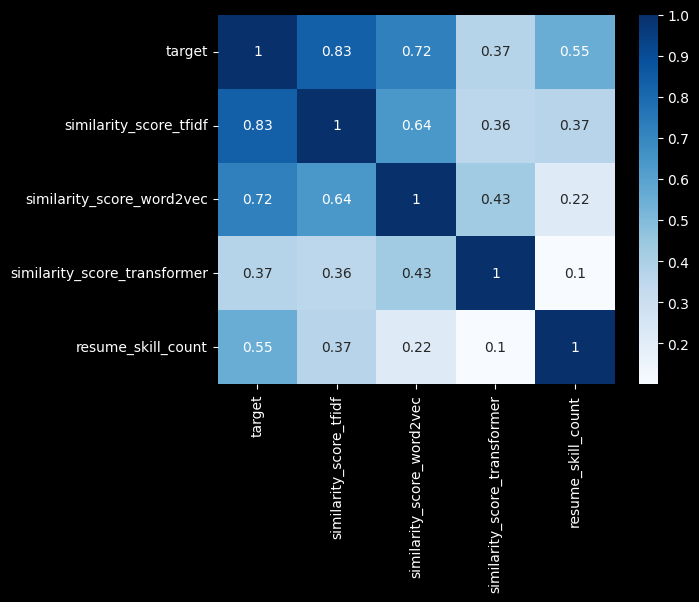

In [83]:
sns.heatmap(phik_matrix(df[['target', 'similarity_score_tfidf', 'similarity_score_word2vec', 'similarity_score_transformer', 'resume_skill_count']]), cmap='Blues', annot=True);

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

Построим тепловую карту нелинейной зависимости новых признаков и целевой переменной.

</div>

<div style="background-color: #98FB98; color: black; padding: 10px; border-radius: 5px;">

***ВЫВОД***

**Что было сделано с датасетом в ходе EDA**

- Очистили датасет от пропущенных значений (или придумали, как их заменить), данные были приведены в порядок и нормализованы. Выбросы, ошибки были удалены
- Удалили признаки зарплатных вилок, так как они имели подавляющее большинство пропусков и не могли быть адекватно заменены.
- Датасет был построен, как декартово произведение вакансий и резюме (3 409 вакансий, 20 845 резюме), из которых только 332 330 пар были оценены.

**Интересные наблюдения**

- Возраст и зарплата имеют колоколообразное распределение медиана зарплат приходится на средний возраст.
- Возраст и опыт - сонаправленные признаки, понятное дело
- Зарплата опыт и корреляция умеренно положительная: более опытные кандидаты ожидают вышее вознаграждение.
- Последний опыт и зарплата - отмечена отрицательная взаимосвязь: кандидаты, долго работающие на одном месте, в среднем ожидают меньше


**Половые и возрастные дискриминации в датасете**

- Мужчины получают приглашения примерно на 42 % чаще, чем женщины.
- С возрастом доля отказов растёт у обоих полов, но у женщин резче
- Активно ищущие работу кандидаты получают заметно больше приглашений, чем те, кто только открыт предложениям
- В дальнейшем учтем факторы пола, возраста, статуса поиска работы - они имеют влияние на целевую переменную
- В будущих итерациях устраним сильную мультиколлинеарную зависимость между признаками (возраст, опыт общий, опыт последнего места)
- Также, в будущем построим новый признак учет локаций (возможно, возьмем расстояние между ними)

**Оценка - построили признаки и как они скоррелированы с разметкой**

Добавили 4 разных признака для оценки сходства между признаками вакансий и резюме, получились следующие результаты:
- TF-IDF - пока что главный предиктор совпадения, есть идеи, почему так связано, в первую очередь из-за способа разметки, будем уточнять результат признака в дальнейшем
- Word2Vec - слабее, отражает лишь частичное тематическое совпадение
- Transformer - улавливает смысловое сходство, полезен для неточных формулировок
- resume_skill_count - хорошая корреляция, будем использовать в дальнейшем

**Что дальше?**

- Попробуем другие модели для transformer
- Построим новые фичи из признаков, которые не были задействованы на данном этапе
- Будем тестировать разные комбинации признаков
- Дополним датасет с связкой резюме - вакансия, которые не подходят, чтобы скорректировать работу признаков (относительно реальной доли принятия резюме на практике)

</div>